# Bidirectional stacked RNNs with LSTM/GRU cells HW3

## Download GloVe Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove*.zip

## Imports


In [ ]:
import os
import random

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('popular')
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

!pip install torchmetrics
import torchmetrics

## Transform GloVe embeddings to Word2Vec format

In [ ]:
glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

## Sets the seed of the entire notebook so results are the same every time we run

In [ ]:
def set_seed(seed = 1234):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

## Load Data Set

In [ ]:
#Reading the csv file
#csv outline [index|url|rating|review]
df = pd.read_csv("/content/imdb-reviews.csv", sep='\t')

#we make a column with {0, 1} based on rating
df["result"] = np.where(df["rating"] <= 4, 0, 1)

##### !! put the path for the test dataset here  !! #######
test_df = pd.DataFrame()

## Data Pre-processing

In [ ]:
def data_preprocessing(df):
  # remove html tags
  df['review'] = df['review'].apply(lambda s: re.sub('<.*?>', '', s))

  # remove special chars and numbers
  df['review'] = df['review'].str.replace("[^A-Za-z]+", ' ', regex=True)

  # tokenize
  df['review'] = df['review'].apply(word_tokenize)

  # remove stopwords
  df['review'] = df['review'].apply(lambda s: ([word.lower() for word in s if word not in (stopwords)]))

  # lemmatize
  df['review'] = df['review'].apply(lambda s: ([lemmatizer.lemmatize(word) for word in s]))

  # we don't use stemming cause it ruins some words and then we can't find them in glove

  return df

df = data_preprocessing(df)

#we also processing the test data if exists
if not test_df.empty:
  test_df = data_preprocessing(test_df)

## Create the Set of Tensors for the Reviews

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(w2v_output_file, datatype=float, binary=False)

In [ ]:
model_dict = {}
tensors_x = []
tensors_y = []

#we make the word2vec a dict to have fast searches
for word in word2vec.index2entity:
  model_dict[word] = word2vec.get_vector(word)

def reviews_to_tensors(df):

  #iterate through all of the reviews and results
  for (review, result) in zip(df['review'], df['result']):

    ##########################  tfidf ##########################

    # tfidf = TfidfVectorizer()
    # response = tfidf.fit_transform(review)

    # feature_array = np.array(tfidf.get_feature_names())
    # tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

    # importand_words = feature_array[tfidf_sorting][:25]
    
    ############ replace review in for with importand_words ############

    #for each review keep in a dict only the distinct words
    review_dict = {}
    for word in review:
      if review_dict.get(word) == None:
        review_dict[word] = len(review_dict)
    
    #for each distict word get the vector
    tensor_x = np.zeros(300)
    tensor_y = [float(result)]
    count = 0

    for word in review_dict:
        #if vector exist add it in review_vectors
        if word in model_dict:
          #add up all vectors
          tensor_x += model_dict[word]
          count += 1
    
    #devide final vector by the sum of words
    tensor_x /= count

    #add tensor to the list
    tensors_x.append(torch.tensor(tensor_x, dtype=torch.float))
    tensors_y.append(torch.tensor(tensor_y, dtype=torch.float))

  #stack all the tensors
  x = torch.stack(tensors_x)
  y = torch.stack(tensors_y)

  return x, y

x, y = reviews_to_tensors(df)

## Split Train and Test Sets

In [ ]:
#split the tensors to train and test sets
#we dont use random_state par cause we have used the set_seed function
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.9)

In [ ]:
#if case for running the test dataframe
if not test_df.empty:
  test_df['result'] = np.where(test_df['rating'] <= 4, 0, 1)
  X_test, Y_test = reviews_to_tensors(test_df)

## Evaluation Functions

In [ ]:
accuracy = torchmetrics.Accuracy(task='binary', num_classes=1)
precission = torchmetrics.Precision(task='binary', num_classes=1)
recall = torchmetrics.Recall(task='binary', num_classes=1)
f1 = torchmetrics.F1Score(task='binary', num_classes=1)

## Define RNN class

In [ ]:
class RNN(nn.Module):

    def __init__(self, cell_type, output_size, input_size, hidden_size, num_layers, dropout):
        super(RNN, self).__init__()

        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        cells = {
        "LSTM"  : nn.LSTM,
        "GRU"   : nn.GRU
        }

        self.cell_type = cell_type
        self.rnn = cells[cell_type](
            input_size=input_size,        #The number of expected features in the input x
            hidden_size=self.hidden_size, #The number of features in the hidden state h
            num_layers=self.num_layers,   #Number of recurrent layers (>=2 means stacking two RNNs together to form a stacked RNN)
            batch_first=True,             #If True, then the input and output tensors are provided as (batch, seq, feature)
            dropout=dropout,              #Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout
            bidirectional=True            #If True, becomes a bidirectional RNN
        )

        # simple net
        # self.linear = nn.Linear(self.hidden_size*2,self.output_size) # we mul *2 cause one layer goin forward one backward
        # self.out = nn.Sigmoid()

        self.linear1 = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size, int(self.hidden_size/2))
        self.linear3 = nn.Linear(int(self.hidden_size/2), int(self.hidden_size/4))
        self.linear4 = nn.Linear(int(self.hidden_size/4), self.output_size)
        self.relu = nn.ReLU()
        self.out = nn.Sigmoid()


    def forward(self, x):

      if self.cell_type == 'LSTM':
        r_out, (h_n, h_c) = self.rnn(x) 
      else:
        r_out, h_n = self.rnn(x)

      # out = self.linear(r_out)
      # out = self.out(out)

      out = self.linear1(r_out)
      out = self.relu(out)
      out = self.linear2(out)
      out = self.relu(out)
      out = self.linear3(out)
      out = self.relu(out)
      out = self.linear4(out)
      out = self.out(out)

      return out


## Initialize the train and test dataloader

In [ ]:
def InitialiseDataloaders(batch_size):
  #Initialise dataloader
  dataset_train = torch.utils.data.TensorDataset(X_train, Y_train)
  dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)

  dataset_test = torch.utils.data.TensorDataset(X_test, Y_test)
  dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

  return dataloader_train, dataloader_test

## Network Train and Test Functions

In [ ]:
input_size = X_train.shape[1]
output_size = 1

#List for the plots
list_loss_train_all = []
list_loss_train = []
list_loss_test = []

list_accuracy_train = []
list_accuracy_test = []

def train_test_net(input_size, output_size, cell_type, hidden_size, num_layers, dropout, batch_value, learning_rate, clip_value):
  
  list_loss_train_all.clear()
  list_loss_train.clear()
  list_loss_test.clear()

  list_accuracy_train.clear()
  list_accuracy_test.clear()

  torch.set_grad_enabled(True)

  #setup model
  net = RNN(cell_type=cell_type, output_size=output_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

  #optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  #loss func
  loss_func = nn.BCELoss()

  #create dataloaders
  dataloader_train, dataloader_test = InitialiseDataloaders(batch_value)

  #set the net ready to train
  net.train()

  nepoch = 8

  for epoch in range(nepoch):
    batch_losses_train = 0
    batch_accuracy_train = 0
    batch_precission_train = 0
    batch_recall_train = 0
    batch_f1_train = 0

    batch_losses_test = 0
    batch_accuracy_test = 0
    batch_precission_test = 0
    batch_recall_test = 0
    batch_f1_test = 0

    #for every epoch we train the model
    for x_batch, y_batch in dataloader_train:

      #Delete previously stored gradients
      optimizer.zero_grad()

      y_pred = net(x_batch)

      #we find loss
      loss = loss_func(y_pred, y_batch)

      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()

      #clip gradients
      if clip_value > 0 :
        torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)

      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()

      list_loss_train_all.append(loss.item())
      batch_losses_train += loss.item()
      batch_accuracy_train += accuracy(torch.round(y_pred), y_batch)
      batch_precission_train += precission(torch.round(y_pred), y_batch)
      batch_recall_train += recall(torch.round(y_pred), y_batch)
      batch_f1_train += f1(torch.round(y_pred), y_batch)

    #keep values for the curves
    list_loss_train.append(batch_losses_train/len(dataloader_train))
    list_accuracy_train.append(batch_accuracy_train/len(dataloader_train))

    print(f"Epoch {epoch}")
    print(f"  Train {epoch:3}: Loss = {batch_losses_train/len(dataloader_train):.5f} Accuracy = {batch_accuracy_train/len(dataloader_train):.5f} Precission = {batch_precission_train/len(dataloader_train):.5f} Recall = {batch_recall_train/len(dataloader_train):.5f} F1 = {batch_f1_train/len(dataloader_train):.5f}")

    #for every epoch we test the model
    net.eval()

    for x_batch, y_batch in dataloader_test:
        y_pred = net(x_batch)

        batch_losses_test += loss_func(y_pred, y_batch).item()
        batch_accuracy_test += accuracy(torch.round(y_pred), y_batch)
        batch_precission_test += precission(torch.round(y_pred), y_batch)
        batch_recall_test += recall(torch.round(y_pred), y_batch)
        batch_f1_test += f1(torch.round(y_pred), y_batch)
        
    #keep values for the curves
    list_loss_test.append(batch_losses_test/len(dataloader_test))
    list_accuracy_test.append(batch_accuracy_test/len(dataloader_test))

    print(f"  Test {epoch:4}: Loss = {batch_losses_test/len(dataloader_test):.5f} Accuracy = {batch_accuracy_test/len(dataloader_test):.5f} Precission = {batch_precission_test/len(dataloader_test):.5f} Recall = {batch_recall_test/len(dataloader_test):.5f} F1 = {batch_f1_test/len(dataloader_test):.5f}")
    
    # Return to training mode
    net.train()

  #finds best combination base on f1 metric from test
  return batch_f1_test/len(dataloader_test), net

In [ ]:
def test_net(saved_model, batch_value=256):
  #loss func
  loss_func = nn.BCELoss()

  #create dataloaders
  _, dataloader_test = InitialiseDataloaders(batch_value)

  batch_losses_test = 0
  batch_accuracy_test = 0
  batch_precission_test = 0
  batch_recall_test = 0
  batch_f1_test = 0

  saved_model.eval()

  for x_batch, y_batch in dataloader_test:
      y_pred = saved_model(x_batch)

      batch_losses_test += loss_func(y_pred, y_batch).item()
      batch_accuracy_test += accuracy(torch.round(y_pred), y_batch)
      batch_precission_test += precission(torch.round(y_pred), y_batch)
      batch_recall_test += recall(torch.round(y_pred), y_batch)
      batch_f1_test += f1(torch.round(y_pred), y_batch)
      
  print(f"Test Loss = {batch_losses_test/len(dataloader_test):.5f} Accuracy = {batch_accuracy_test/len(dataloader_test):.5f} Precission = {batch_precission_test/len(dataloader_test):.5f} Recall = {batch_recall_test/len(dataloader_test):.5f} F1 = {batch_f1_test/len(dataloader_test):.5f}")
  
  return

## LSTM / GRU Parameters Tuning

In [ ]:
# ============= Best parameters for LSTM =========== #
# cell_type = 'LSTM'
# hidden_size = 64
# num_layers = 3
# dropout = 0.4
# clip_value = 5
# batch_value = 256
# learning_rate = 1e-3
# ================================================== #

# ============= Best parameters for GRU =========== #
# cell_type = 'GRU'
# hidden_size = 128
# num_layers = 4
# dropout = 0.4
# clip_value = 4
# batch_value = 256
# learning_rate = 1e-3
# ================================================== #

### Hidden Size Tuning

In [ ]:
def hidden_size_tune(cell_type, num_layers=2, dropout=0.0, batch_value=64, learning_rate=1e-3, clip_value=0):
  all_hidden_sizes = []

  for hidden_size_n in [64, 128, 256]:
    print("New training for hidden size = " + str(hidden_size_n))
    curr, _ = train_test_net(input_size=input_size, output_size=output_size, cell_type=cell_type, hidden_size=hidden_size_n, num_layers=num_layers, dropout=dropout, batch_value=batch_value, learning_rate=learning_rate, clip_value=clip_value)
    all_hidden_sizes.append((curr, hidden_size_n))
  
  all_hidden_sizes.sort(reverse=True)
  best_f1_hidden_size, best_hidden_size = all_hidden_sizes[0]

  print("Best number of hidden_size for " + cell_type + " = " + str(best_hidden_size) + " with f1 score: " + str(best_f1_hidden_size))

  return all_hidden_sizes

#hidden_sz_LSTM = hidden_size_tune('LSTM')
#hidden_sz_GRU = hidden_size_tune('GRU')

Best number of hidden_size for LSTM = 64 with f1 score: 0.76175
Best number of hidden_size for GRU = 128 with f1 score: 0.7663


### Number of Layers Tuning

In [ ]:
def num_layers_tune(cell_type, hidden_size=64, dropout=0.0, batch_value=64, learning_rate=1e-3, clip_value=0):
  all_num_layers = []

  for num_layers_n in [2, 3, 4, 5]:
    print("New training for num_layer = " + str(num_layers_n))
    curr, _ = train_test_net(input_size=input_size, output_size=output_size, cell_type=cell_type, hidden_size=hidden_size, num_layers=num_layers_n, dropout=dropout, batch_value=batch_value, learning_rate=learning_rate, clip_value=clip_value)
    all_num_layers.append((curr, num_layers_n))

  all_num_layers.sort(reverse=True)
  best_f1_num_layer, best_num_layer = all_num_layers[0]

  print("Best number of layers for " + cell_type + " = " + str(best_num_layer) + " with f1 score: " + str(best_f1_num_layer))

  return all_num_layers

#num_layers_LSTM = num_layers_tune('LSTM', hidden_size=64)
#num_layers_GRU = num_layers_tune('GRU', hidden_size=128)

Best number of layers for LSTM = 3 with f1 score: 0.73890
Best number of layers for GRU = 4 with f1 score: 0.7618


### Dropout Tuning

In [ ]:
def dropout_tune(cell_type, hidden_size=64, num_layers=2, batch_value=64, learning_rate=1e-3, clip_value=0):
  all_dropouts = []

  for dropout_n in [0.1, 0.25, 0.4, 0.5]:
    print("New training for dropout = " + str(dropout_n))
    curr, _ = train_test_net(input_size=input_size, output_size=output_size, cell_type=cell_type, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_n, batch_value=batch_value, learning_rate=learning_rate, clip_value=clip_value)
    all_dropouts.append((curr, dropout_n))

  all_dropouts.sort(reverse=True)
  best_f1_dropout, best_dropout = all_dropouts[0]

  print("Best number of dropout for " + cell_type + " = " + str(best_dropout) + " with f1 score: " + str(best_f1_dropout))

  return all_dropouts

#dropout_LSTM = dropout_tune('LSTM', hidden_size=64, num_layers=3)
#dropout_GRU = dropout_tune('GRU', hidden_size=128, num_layers=4)

Best number of dropout for LSTM = 0.4 with f1 score: 0.75006
Best number of dropout for GRU = 0.4 with f1 score: 0.7628


### Batch Value Tuning

In [ ]:
def batch_tune(cell_type, hidden_size=64, num_layers=2, dropout=0.0, learning_rate=1e-3, clip_value=0):
  all_batch_values = []

  for batch_value_n in [64, 128, 256, 512, 1024]:
    print("New training for batch value = " + str(batch_value_n))
    curr, _ = train_test_net(input_size=input_size, output_size=output_size, cell_type=cell_type, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_value=batch_value_n, learning_rate=learning_rate, clip_value=clip_value)
    all_batch_values.append((curr, batch_value_n))

  all_batch_values.sort(reverse=True)
  best_f1_batch_value, best_batch_value = all_batch_values[0]

  print("Best number of batch value for " + cell_type + " = " + str(best_batch_value) + " with f1 score: " + str(best_f1_batch_value))

#batch_LSTM = batch_tune('LSTM', hidden_size=64, num_layers=3, dropout=0.4)
#batch_GRU = batch_tune('GRU', hidden_size=128, num_layers=4, dropout=0.4)

Best number of batch value for LSTM = 256 with f1 score: 0.75468
Best number of batch value for GRU = 256 with f1 score: 0.75628


### Learning rate Tuning

In [ ]:
def learning_rate_tune(cell_type, hidden_size=64, num_layers=2, dropout=0.0, batch_value=256, clip_value=0):
  all_learning_rates = []

  for learning_rate_n in [1e-3, 1e-4, 1e-5]:
    print("New training for learning rate value = " + str(learning_rate_n))
    curr, _ = train_test_net(input_size=input_size, output_size=output_size, cell_type=cell_type, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_value=batch_value, learning_rate=learning_rate_n, clip_value=clip_value)
    all_learning_rates.append((curr, learning_rate_n))

  all_learning_rates.sort(reverse=True)
  best_f1_learning_rate, best_learning_rate = all_learning_rates[0]

  print("Best number of learning rate value for " + cell_type + " = " + str(best_learning_rate) + " with f1 score: " + str(best_f1_learning_rate))

  return all_learning_rates

#learning_rate_lstm = learning_rate_tune('LSTM', hidden_size=64, num_layers=3, dropout=0.4, batch_value=256)
#learning_rate_gru = learning_rate_tune('GRU', hidden_size=128, num_layers=4, dropout=0.4, batch_value=256)

Best number of learning rate value for LSTM = 1e-3 with f1 score: 0.75872
Best number of learning rate value for GRU = 1e-3 with f1 score: 0.75446


### Clipping Tuning

In [ ]:
def clipping_tune(cell_type, hidden_size=64, num_layers=2, dropout=0.0, batch_value=256, learning_rate=1e-3):
  all_clipping_values = []

  for clipping_n in [1, 2, 3, 4, 5]:
    print("New training for clip value = " + str(clipping_n))
    curr, _ = train_test_net(input_size=input_size, output_size=output_size, cell_type=cell_type, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_value=batch_value, learning_rate=learning_rate, clip_value=clipping_n)
    all_clipping_values.append((curr, clipping_n))

  all_clipping_values.sort(reverse=True)
  best_f1_clipping_value, best_clipping_value = all_clipping_values[0]

  print("Best number of clipping value for " + cell_type + " = " + str(best_clipping_value) + " with f1 score: " + str(best_f1_clipping_value))

#clipping_LSTM = clipping_tune('LSTM', hidden_size=64, num_layers=3, dropout=0.4, batch_value=256, learning_rate=1e-3)
#clipping_GRU = clipping_tune('GRU', hidden_size=128, num_layers=4, dropout=0.4, batch_value=256, learning_rate=1e-3)

Best number of clipping value for LSTM = 5 with f1 score: 0.76410
Best number of clipping value for GRU = 4 with f1 score: 0.75962


### LSTM vs GRU

In [ ]:
# these hyper-parameters are the best overall for lstm
# f1_LSTM, _ = train_test_net(input_size=input_size, output_size=output_size, cell_type='LSTM', hidden_size=64, num_layers=3, dropout=0.4, batch_value=256, learning_rate=1e-3, clip_value=5)
# print("f1 score " + str(f1_LSTM) + " for LSTM cells")

f1 score 0.84529 for LSTM cells


In [ ]:
# these hyper-parameters are the best overall for lstm
# resGRU, _ = train_test_net(input_size=input_size, output_size=output_size, cell_type='GRU', hidden_size=128, num_layers=4, dropout=0.4, batch_value=256, learning_rate=1e-3, clip_value=4)
# print("f1 score " + str(resGRU) + " for GRU cells")

f1 score 0.84456 for GRU cells


## Final Model

#### Train and Test

In [45]:
_ , final_net = train_test_net(input_size=input_size, output_size=output_size, cell_type='LSTM', hidden_size=64, num_layers=3, dropout=0.4, batch_value=256, learning_rate=1e-3, clip_value=5)

Epoch 0
  Train   0: Loss = 0.57860 Accuracy = 0.65502 Precission = 0.61244 Recall = 0.68368 F1 = 0.60967
  Test    0: Loss = 0.41801 Accuracy = 0.80612 Precission = 0.88201 Recall = 0.71310 F1 = 0.78814
Epoch 1
  Train   1: Loss = 0.39744 Accuracy = 0.82361 Precission = 0.82532 Recall = 0.82437 F1 = 0.82257
  Test    1: Loss = 0.37208 Accuracy = 0.82786 Precission = 0.84982 Recall = 0.80333 F1 = 0.82544
Epoch 2
  Train   2: Loss = 0.38064 Accuracy = 0.83248 Precission = 0.83334 Recall = 0.83339 F1 = 0.83167
  Test    2: Loss = 0.36723 Accuracy = 0.83421 Precission = 0.85123 Recall = 0.81643 F1 = 0.83301
Epoch 3
  Train   3: Loss = 0.37570 Accuracy = 0.83438 Precission = 0.83417 Recall = 0.83606 F1 = 0.83364
  Test    3: Loss = 0.36480 Accuracy = 0.83362 Precission = 0.84273 Recall = 0.82709 F1 = 0.83443
Epoch 4
  Train   4: Loss = 0.37120 Accuracy = 0.83770 Precission = 0.83729 Recall = 0.83969 F1 = 0.83712
  Test    4: Loss = 0.36347 Accuracy = 0.83368 Precission = 0.83683 Recall = 0

#### Test saved model

In [33]:
saved_model = torch.jit.load('myNN.pt')
test_net(saved_model=saved_model)

Test Loss = 0.36590 Accuracy = 0.83281 Precission = 0.84069 Recall = 0.82842 F1 = 0.83404


## Plots

### BCELoss Plot

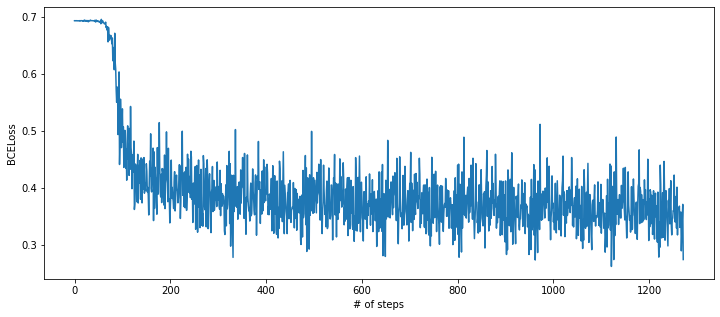

In [46]:
plt.figure(figsize=(12,5))
plt.plot(list_loss_train_all)
plt.xlabel('# of steps')
plt.ylabel('BCELoss')
plt.show()

### Optimization Learning Curve

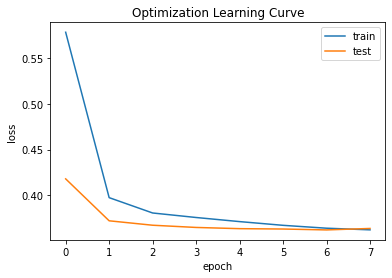

In [47]:
plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(list_loss_train, label = 'train')
plt.plot(list_loss_test, label = 'test')
plt.title('Optimization Learning Curve')
plt.legend()

### Performance Learning Curve

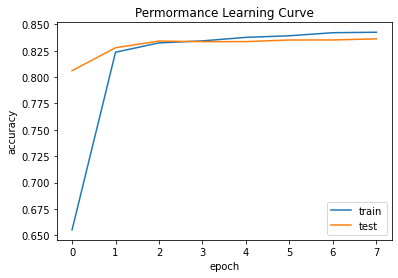

In [48]:
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.plot(list_accuracy_train, label = 'train')
plt.plot(list_accuracy_test, label = 'test')

plt.title('Permormance Learning Curve')
plt.legend()

### ROC curve

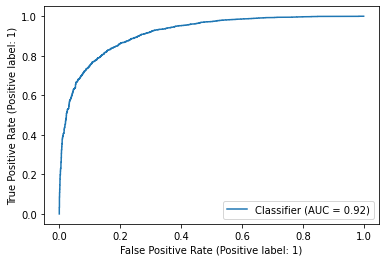

In [44]:
y_pred = final_net(X_test)
RocCurveDisplay.from_predictions(Y_test, y_pred.detach().numpy())

## Save and load a NN with pyTorch

In [49]:
#model_scripted = torch.jit.script(final_net)
#model_scripted.save('myNN.pt')